In [83]:
library(rstatix)
library(readr)
library(afex)
library(performance)
library(RCurl)
library(optimx)
library(parallel)
library(minqa)
library(ggpubr)
library(ez) 
# https://github.com/mike-lawrence/ez
# library(lme4)

# Forced-choice survey LMER

In [84]:
df = read_csv("../clean_data_mturk/forced_choice_emotion_mturk_long_format_lmer.csv")


── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  participantId = col_double(),
  photoId = col_character(),
  emotion = col_character(),
  ethnicity = col_character(),
  sex = col_character(),
  age = col_character(),
  label = col_character(),
  url = col_character(),
  sentimentScore = col_double(),
  sexC = col_double(),
  ageC = col_double(),
  ethnicityC = col_double()
)




## Useful links about fitting LMER 
- https://bbolker.github.io/mixedmodels-misc/glmmFAQ.html#singular-models-random-effect-variances-estimated-as-zero-or-correlations-estimated-as---1
- https://stats.stackexchange.com/questions/242109/model-failed-to-converge-warning-in-lmer
- https://easystats.github.io/blog/posts/performance_check_collinearity/
- https://stats.stackexchange.com/questions/449042/is-a-singular-fit-with-no-correlations-near-1-or-variances-of-zero-a-false
- http://svmiller.com/blog/2018/06/mixed-effects-models-optimizer-checks/
- https://joshua-nugent.github.io/allFit/
- https://rstudio-pubs-static.s3.amazonaws.com/33653_57fc7b8e5d484c909b615d8633c01d51.html
- https://stats.stackexchange.com/questions/323273/what-to-do-with-random-effects-correlation-that-equals-1-or-1
- https://psych.wisc.edu/Brauer/BrauerLab/wp-content/uploads/2014/04/Brauer-and-Curtin-in-press-Psych-Methods.pdf
- https://cran.r-project.org/web/packages/lme4/vignettes/lmerperf.html
- https://rpubs.com/palday/lme4-singular-convergence

## Run model with Nelder-Mead opt

**Determining random effect structure**

**Random Intercept**:
- participantId: repeated measures from same participant
- photoId: repeated measures from same photo

**Random slope**:
- ethnicity: varies *within participantId* and *between items*
- sex: varies *within participantId* and *between items*
- age: varies *within participantId* and *between items*

----
- Random intercept and slope for participantId
- Random intercept for photoId

----

In [85]:
# ---------
# doesn't converge
# ---------

# lmer_fc_uw_max = lmer(
#     sentimentScore ~ 1 + sexC*ethnicityC*ageC + (1 + sexC*ethnicityC*ageC|participantId) + (1 | photoId), 
#     data = df, 
#     REML = FALSE, 
#     control = lmerControl(optimizer ="Nelder_Mead", calc.derivs=FALSE)
# )
# summary(lmer_fc_uw_max)

In [86]:
# -------------
# lacks power because there is only 1 obs per cell of [participantId X photoId]
# -------------

lmer_fc_uw_full = lmer(
    sentimentScore ~ 1 + sexC*ethnicityC + (1 + sexC*ethnicityC|participantId) + (1 | photoId), 
    data = df, 
    REML = FALSE, 
    control = lmerControl(optimizer ="Nelder_Mead", calc.derivs=FALSE)
)
summary(lmer_fc_uw_full)

Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: sentimentScore ~ 1 + sexC * ethnicityC + (1 + sexC * ethnicityC |  
    participantId) + (1 | photoId)
   Data: df
Control: lmerControl(optimizer = "Nelder_Mead", calc.derivs = FALSE)

     AIC      BIC   logLik deviance df.resid 
  2925.0   3040.4  -1446.5   2893.0     9968 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.2452 -0.5310 -0.0126  0.5087  4.1014 

Random effects:
 Groups        Name            Variance  Std.Dev. Corr             
 photoId       (Intercept)     1.042e-01 0.322733                  
 participantId (Intercept)     1.685e-03 0.041045                  
               sexC            7.713e-06 0.002777 -0.74            
               ethnicityC      2.338e-04 0.015292  0.31 -0.30      
               sexC:ethnicityC 1.143e-04 0.010691  0.47 -0.56 -0.18
 Residual                      7.128e-02 0.266978                  
Number of obs: 99

In [87]:
# --------------
# it doesn't address photoId random effect, but it has better power 20+ obs per cell (i.e., participantId )
# --------------

lmer_fc_uw_partial = lmer(
    sentimentScore ~ 1 + sexC*ethnicityC + (1 + sexC*ethnicityC|participantId), 
    data = df, REML = FALSE, 
    control = lmerControl(optimizer ="Nelder_Mead", calc.derivs=FALSE)
)
summary(lmer_fc_uw_partial)

Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: sentimentScore ~ 1 + sexC * ethnicityC + (1 + sexC * ethnicityC |  
    participantId)
   Data: df
Control: lmerControl(optimizer = "Nelder_Mead", calc.derivs = FALSE)

     AIC      BIC   logLik deviance df.resid 
 10765.6  10873.7  -5367.8  10735.6     9969 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.3099 -0.8812 -0.3347  0.9213  1.9457 

Random effects:
 Groups        Name            Variance  Std.Dev. Corr             
 participantId (Intercept)     1.128e-03 0.033593                  
               sexC            3.662e-05 0.006051  0.88            
               ethnicityC      1.780e-04 0.013341  0.56  0.35      
               sexC:ethnicityC 9.158e-05 0.009570 -0.08 -0.31 -0.25
 Residual                      1.708e-01 0.413305                  
Number of obs: 9984, groups:  participantId, 52

Fixed effects:
                  Estimate Std. Error

## Check collinearity

In [88]:
# check_collinearity(lmer_fc_uw_full)

In [89]:
check_collinearity(lmer_fc_uw_partial)

,Term,VIF,SE_factor
,<chr>,<dbl>,<dbl>
1,sexC,1.000065,1.000032
2,ethnicityC,1.000077,1.000039
3,sexC:ethnicityC,1.000025,1.000012


In [90]:
# plot(check_collinearity(lmer_fc_uw_full))

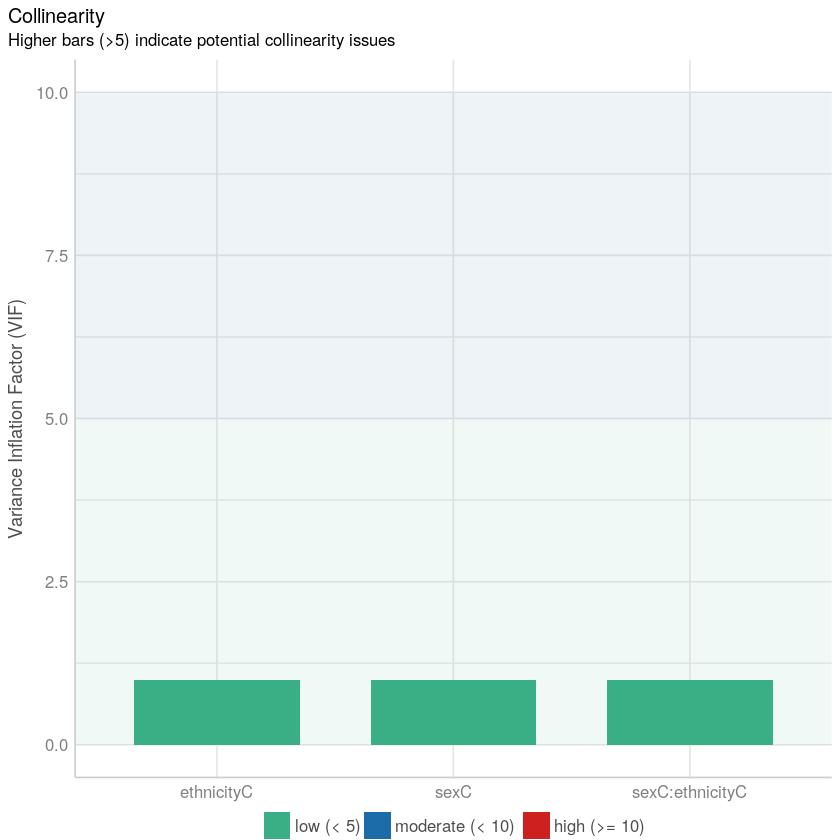

In [91]:
plot(check_collinearity(lmer_fc_uw_partial))

## Check singularity

In [92]:
# https://rstudio-pubs-static.s3.amazonaws.com/33653_57fc7b8e5d484c909b615d8633c01d51.html

# tt = getME(lmer_fc_uw_full,"theta")
# ll = getME(lmer_fc_uw_full,"lower")
# tt_value = min(tt[ll==0])

# https://rstudio-pubs-static.s3.amazonaws.com/33653_57fc7b8e5d484c909b615d8633c01d51.html
tt_p = getME(lmer_fc_uw_partial,"theta")
ll_p = getME(lmer_fc_uw_partial,"lower")
tt_value_p = min(tt_p[ll_p==0])

tt_value_p

[1] 0.006847649

In [93]:
tt_value_p < 0.000001
# probably not a problem

[1] FALSE

In [94]:
theta_p <- getME(lmer_fc_uw_partial,"theta")
## diagonal elements are identifiable because they are fitted
##  with a lower bound of zero ...
diag.element <- getME(lmer_fc_uw_partial,"lower")==0
any(theta_p[diag.element]<1e-5)

# probably not a problem

[1] FALSE

## Testing multiple optimizers


In [95]:
# lmer_fc_uw_m = lmer(sentimentScore ~ 1 + sexC*ethnicityC + (1 + sexC*ethnicityC|participantId), data = df)

In [96]:
# ncores <- detectCores()
# diff_optims <- allFit(lmer_fc_uw_m, maxfun = 1e5, parallel = 'multicore', ncpus = ncores)

In [97]:
# is.OK <- sapply(diff_optims, is, "merMod")
# diff_optims.OK <- diff_optims[is.OK]
# lapply(diff_optims.OK,function(x) x@optinfo$conv$lme4$messages)

In [98]:
# (lliks <- sort(sapply(diff_optims.OK,logLik)))

## Three-way Anova 

### Useful links about fitting ANOVAS
- https://www.datanovia.com/en/lessons/repeated-measures-anova-in-r/
- https://cran.r-project.org/web/packages/effectsize/vignettes/anovaES.html
- https://rpkgs.datanovia.com/rstatix/reference/anova_test.html
- https://stats.stackexchange.com/questions/11079/problem-with-anova-repeated-measures-error-model-is-singular

### Descriptives

In [99]:
df %>%
  group_by(ethnicity, sex, age) %>%
  get_summary_stats(sentimentScore, type = "mean_sd")

ethnicity,sex,age,variable,n,mean,sd
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
bipoc,female,adult,sentimentScore,1248,-0.144,0.426
bipoc,female,child,sentimentScore,1248,-0.081,0.429
bipoc,male,adult,sentimentScore,1248,-0.183,0.398
bipoc,male,child,sentimentScore,1248,-0.111,0.413
white,female,adult,sentimentScore,1248,-0.160,0.417
white,female,child,sentimentScore,1248,-0.087,0.412
white,male,adult,sentimentScore,1248,-0.147,0.395
white,male,child,sentimentScore,1248,-0.149,0.419


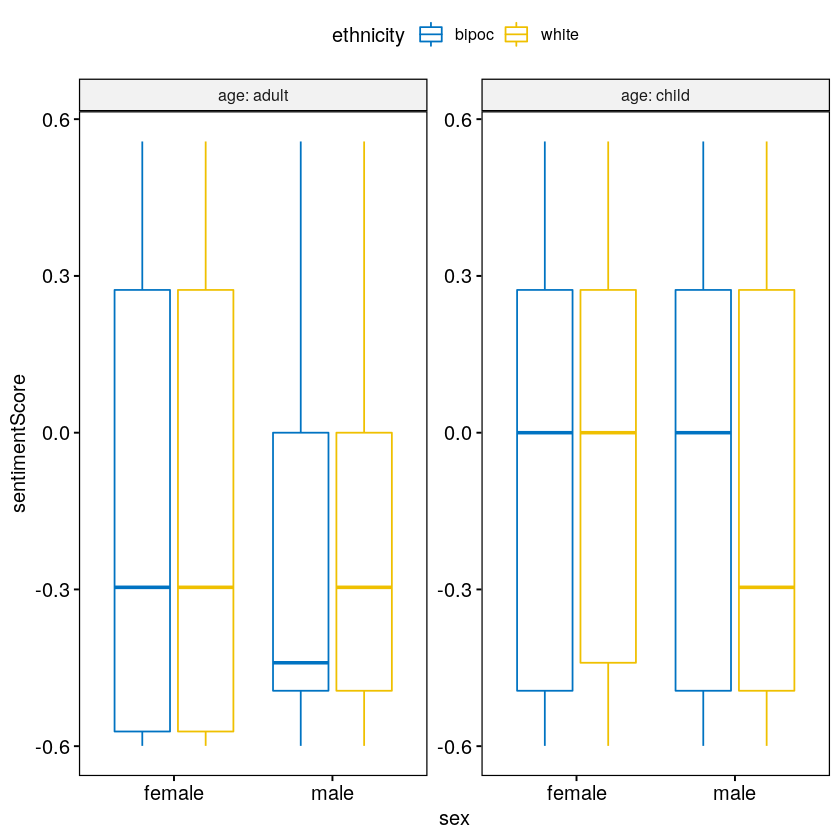

In [100]:
# bxp <- ggboxplot(
#   df, x = "ethnicity", y = "sentimentScore",
#   color = "sex", palette = "jco",
#   facet.by = "age", short.panel.labs = FALSE,
#   scales = "free"
#   )
# bxp

bxp <- ggboxplot(
  df, x = "sex", y = "sentimentScore",
  color = "ethnicity", palette = "jco",
  facet.by = "age", short.panel.labs = FALSE,
  scales = "free"
  )
bxp

### Check assumptions

#### Outliers

In [101]:
df %>% group_by(ethnicity, sex, age) %>% identify_outliers(sentimentScore)

# no outliers

ethnicity,sex,age,participantId,photoId,emotion,label,url,sentimentScore,sexC,ageC,ethnicityC,is.outlier,is.extreme
<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>


#### Normality assumption

In [102]:
# Compute Shapiro-Wilk test for each combinations of factor levels

df %>%
  group_by(ethnicity, sex, age) %>%
  shapiro_test(sentimentScore)

ethnicity,sex,age,variable,statistic,p
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
bipoc,female,adult,sentimentScore,0.8378745,7.961309e-34
bipoc,female,child,sentimentScore,0.8518830,1.205603e-32
bipoc,male,adult,sentimentScore,0.8392209,1.025226e-33
bipoc,male,child,sentimentScore,0.8623537,1.053325e-31
white,female,adult,sentimentScore,0.8415321,1.588814e-33
white,female,child,sentimentScore,0.8725797,9.956419e-31
white,male,adult,sentimentScore,0.8684521,3.955224e-31
white,male,child,sentimentScore,0.8395674,1.094478e-33


In [103]:
7.961309e-34 < 0.05

# not normal

[1] TRUE

#### QQ plot 

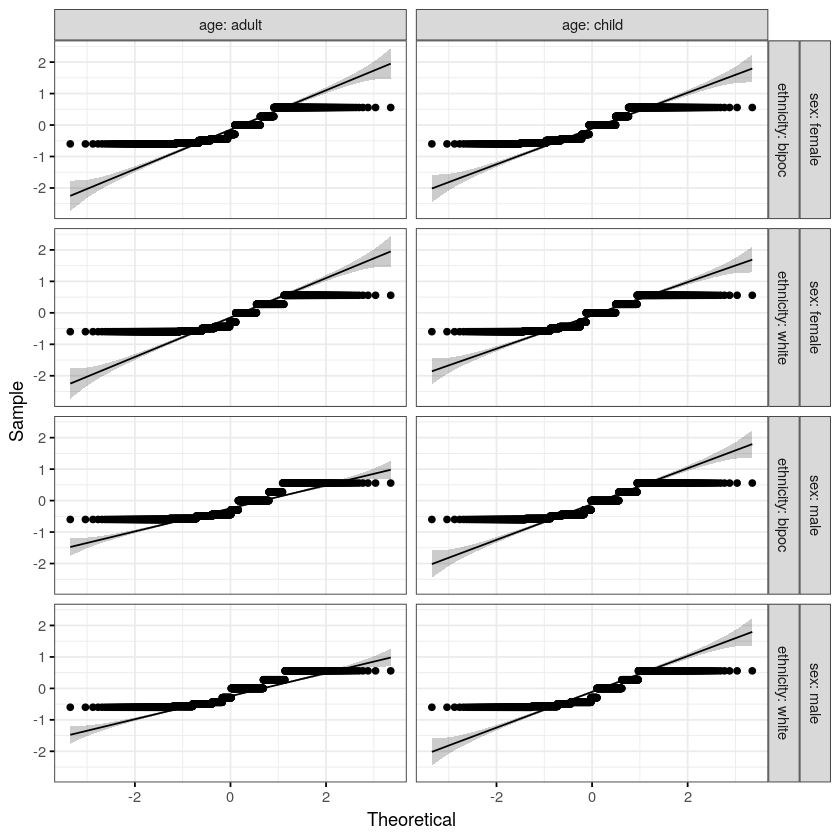

In [104]:
ggqqplot(df, "sentimentScore", ggtheme = theme_bw()) +
  facet_grid(sex + ethnicity ~ age, labeller = "label_both")

**Definetively not normal data**

## Anova 2x2x2 computation 


My design is 2x2x2 fully-crosses, meaning will yield a singular decomposition. 
This is probably why LMER doesn't converge regardless of the optimizer and other hyper-params

Guide: https://www.datanovia.com/en/lessons/repeated-measures-anova-in-r/#summary-statistics-2

In [105]:
df_long = df %>% select(participantId, sex, age, ethnicity, sentimentScore)

In [106]:
df_long = df_long %>% convert_as_factor(participantId, sex, age, ethnicity)

In [107]:
head(df_long)

participantId,sex,age,ethnicity,sentimentScore
<fct>,<fct>,<fct>,<fct>,<dbl>
0,female,adult,bipoc,-0.5719
0,male,child,bipoc,0.0000
0,female,adult,white,0.2732
0,female,child,white,-0.4939
0,male,adult,white,0.0000
0,male,child,white,0.2732


In [108]:
# res.aov <- anova_test(
#   data = df_long, dv = sentimentScore, wid = participantId,
#   within = c(sex, age, ethnicity)
#   )
# get_anova_table(res.aov)

In [109]:
res.aov  = ezANOVA(data=df, wid=.(participantId), dv=.(sentimentScore), within=.(sex, age, ethnicity))
res.aov  

Warning message:
“Converting "participantId" to factor for ANOVA.”
Warning message:
“Converting "sex" to factor for ANOVA.”
Warning message:
“Converting "age" to factor for ANOVA.”
Warning message:
“Converting "ethnicity" to factor for ANOVA.”
Warning message:
“Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.”


,Effect,DFn,DFd,F,p,p<.05,ges
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
2,sex,1,51,34.696800,3.044205e-07,*,0.044310064
3,age,1,51,48.747287,5.812493e-09,*,0.122871401
4,ethnicity,1,51,1.372816,2.467734e-01,,0.001994048
5,sex:age,1,51,11.675911,1.251359e-03,*,0.014267972
6,sex:ethnicity,1,51,1.190732,2.803106e-01,,0.001345696
7,age:ethnicity,1,51,6.294945,1.532789e-02,*,0.013605096
8,sex:age:ethnicity,1,51,19.320724,5.616520e-05,*,0.021860759


In [110]:
format(5.616520e-05, scientific=FALSE)

[1] "0.0000561652"

There is a statistically significant three-way interactions between age, sex, and ethnicity, Anova, $F$(1, 51) = 19.32, $p$ < 0.001, $\eta^2_{g}=0.02$

### Post-hoc tests

https://www.datanovia.com/en/lessons/repeated-measures-anova-in-r/#post-hoc-tests-2

A significant three-way interaction effect can be decomposed into:

- Simple two-way interaction: run two-way interaction at each level of third variable,
- Simple main effect: run one-way model at each level of second variable, and
- Simple pairwise comparisons: run pairwise or other post-hoc comparisons if necessary.

#### Simple two-way interaction

In [111]:
df_adult = df %>% filter(age=='adult')
df_child = df %>% filter(age=='child')

In [112]:
adult.twoway  = ezANOVA(data=df_adult, wid=.(participantId), dv= .(sentimentScore), within=.(sex, ethnicity))
child.twoway  = ezANOVA(data=df_child, wid=.(participantId), dv= .(sentimentScore), within=.(sex, ethnicity))

Warning message:
“Converting "participantId" to factor for ANOVA.”
Warning message:
“Converting "sex" to factor for ANOVA.”
Warning message:
“Converting "ethnicity" to factor for ANOVA.”
Warning message:
“Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.”
Warning message:
“Converting "participantId" to factor for ANOVA.”
Warning message:
“Converting "sex" to factor for ANOVA.”
Warning message:
“Converting "ethnicity" to factor for ANOVA.”
Warning message:
“Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.”


In [113]:
adult.twoway

,Effect,DFn,DFd,F,p,p<.05,ges
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
2,sex,1,51,3.620761,0.0627153608,,0.009289937
3,ethnicity,1,51,1.717396,0.1958998139,,0.005466305
4,sex:ethnicity,1,51,16.678599,0.0001564685,*,0.034762297


In [114]:
child.twoway

,Effect,DFn,DFd,F,p,p<.05,ges
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
2,sex,1,51,42.371759,3.241627e-08,*,0.09796461
3,ethnicity,1,51,6.241895,1.574087e-02,*,0.02471915
4,sex:ethnicity,1,51,5.092612,2.834227e-02,*,0.01211572


There is statistically significant simple two-way interaction between **sex** and **ethnicity** for "adults", F(1, 51) = 16.67, p < 0.0001, and for "childrens" , F(1, 51) = 5.09, p < 0.0001.

#### Simple simple main effects

In [115]:
df_adult_male = df_adult %>% filter(sex=='male')
df_child_female = df_child %>% filter(sex=='female')

In [116]:
adult_male.main  = ezANOVA(data=df_adult_male, wid=.(participantId), dv= .(sentimentScore), within=.(ethnicity))
adult_female.main  = ezANOVA(data=df_child_female, wid=.(participantId), dv= .(sentimentScore), within=.(ethnicity))

Warning message:
“Converting "participantId" to factor for ANOVA.”
Warning message:
“Converting "ethnicity" to factor for ANOVA.”
Warning message:
“Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.”
Warning message:
“Converting "participantId" to factor for ANOVA.”
Warning message:
“Converting "ethnicity" to factor for ANOVA.”
Warning message:
“Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.”


In [117]:
adult_male.main

,Effect,DFn,DFd,F,p,p<.05,ges
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
2,ethnicity,1,51,11.30428,0.001472679,*,0.05688387


In [118]:
adult_female.main

,Effect,DFn,DFd,F,p,p<.05,ges
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
2,ethnicity,1,51,0.3392085,0.5628526,,0.002063681


There is a statistically significant simple main effect of **ethnicity** on **sentiment-score** for the "**adult-males**" group F(1, 51) = 11.3, p = 0.001, but not for the "adult-female" group.

#### Simple Pairwise comparisons

In [119]:
pwc <- df %>%
  group_by(age, sex) %>%
  pairwise_t_test(sentimentScore ~ ethnicity, paired = TRUE, p.adjust.method = "bonferroni") %>%
  select(-df, -statistic) # Remove details

pwc

sex,age,.y.,group1,group2,n1,n2,p,p.adj,p.adj.signif
<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<chr>
female,adult,sentimentScore,bipoc,white,1248,1248,0.335,0.335,ns
male,adult,sentimentScore,bipoc,white,1248,1248,0.025,0.025,*
female,child,sentimentScore,bipoc,white,1248,1248,0.681,0.681,ns
male,child,sentimentScore,bipoc,white,1248,1248,0.026,0.026,*


In [120]:
pwc %>% filter(sex == "male", age == "adult") %>%
  select(-p)     # remove p columns

sex,age,.y.,group1,group2,n1,n2,p.adj,p.adj.signif
<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<chr>
male,adult,sentimentScore,bipoc,white,1248,1248,0.025,*


$F$(1, 51) = 19.32, $p$ < 0.001, $\eta^2_{g}=0.02$

### Visualization forced-choice: box plots with p-values

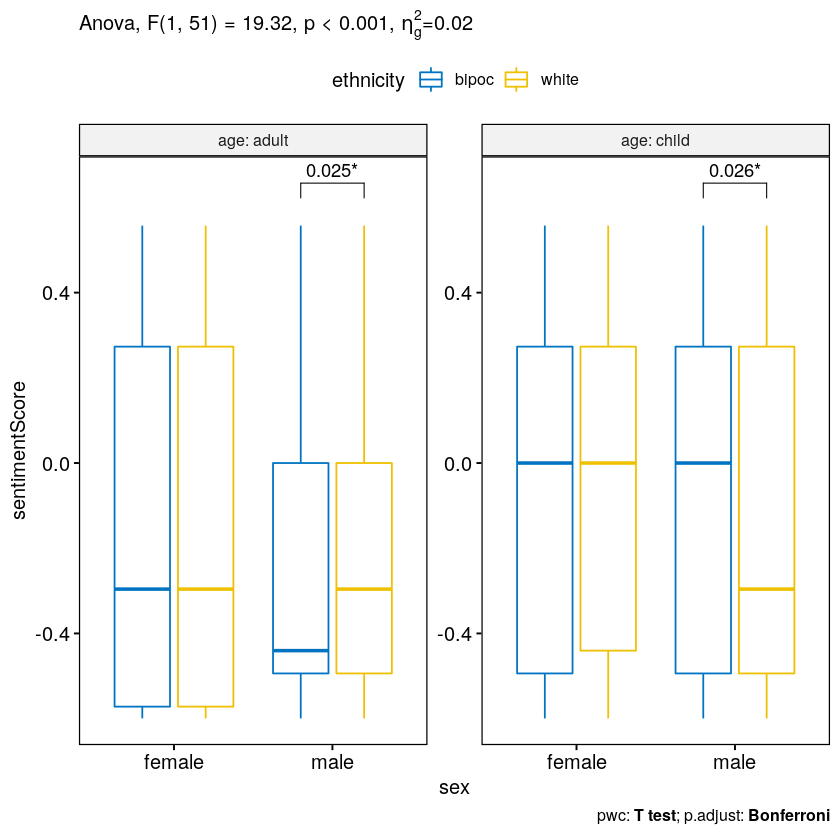

In [124]:
# subtitle_3way_anova = "Anova, $F$(1, 50) = 5.19, $p$ = 0.03, $\\eta^2_{g}=0.009$"
subtitle_3way_anova = expression(paste("Anova, F(1, 51) = 19.32, p < 0.001, ", eta[g]^2, "=0.02"))
pwc <- pwc %>% add_xy_position(x = "sex")

bxp +  
  stat_pvalue_manual(
    pwc, hide.ns = TRUE, bracket.nudge.y = 0.1,
    label = "{p.adj}{p.adj.signif}"
    ) +
  labs(
    subtitle = subtitle_3way_anova,
    caption = get_pwc_label(pwc)
  )

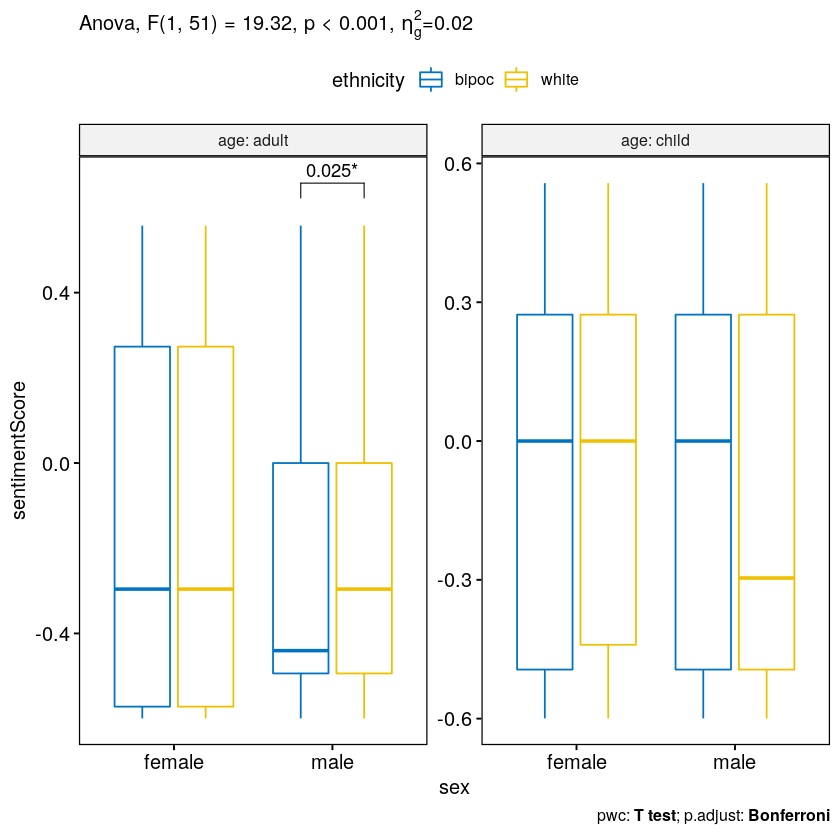

In [123]:
# # subtitle_3way_anova = "Anova, $F$(1, 50) = 5.19, $p$ = 0.03, $\\eta^2_{g}=0.009$"
# subtitle_3way_anova = expression(paste("Anova, F(1, 51) = 19.32, p < 0.001, ", eta[g]^2, "=0.02"))
# pwc <- pwc %>% add_xy_position(x = "sex")

# pwc.filtered <- pwc %>% 
#   filter(sex == "male", age == "adult")

# bxp +  
#   stat_pvalue_manual(
#     pwc.filtered, hide.ns = TRUE, bracket.nudge.y = 0.1,
#     label = "{p.adj}{p.adj.signif}"
#     ) +
#   labs(
#     subtitle = subtitle_3way_anova,
#     caption = get_pwc_label(pwc)
#   )

In [125]:
ggsave("../clean_data_mturk/anova_3way_test_forced_choice_mturk.png")
ggsave("../../emotions_dashboard/data/anova_3way_test_forced_choice_mturk.png")

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



## Report

-------------------




***PENDING...***



-------------------

## Anova agregated across ethnicity for between-effect

In [126]:
mDf = aggregate(sentimentScore ~ participantId + ethnicityC, data=df, FUN=mean)

In [127]:
summary(aov(sentimentScore ~ ethnicityC, data=mDf))     # ANOVA with just the between-effect

             Df  Sum Sq   Mean Sq F value Pr(>F)
ethnicityC    1 0.00099 0.0009863   0.413  0.522
Residuals   102 0.24367 0.0023889               

In [128]:
# Images depicting caucasian faces 

In [129]:
mDf %>%
  group_by(ethnicityC) %>%
  get_summary_stats(sentimentScore, type = "mean_sd")

ethnicityC,variable,n,mean,sd
<dbl>,<chr>,<dbl>,<dbl>,<dbl>
-0.5,sentimentScore,52,-0.130,0.047
0.5,sentimentScore,52,-0.136,0.051


# Free-labeling

In [130]:
df_free = read_csv("../clean_data_mturk/free_labeling_emotion_mturk_long_format_lmer.csv")


── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  participantId = col_double(),
  photoId = col_character(),
  emotion = col_character(),
  ethnicity = col_character(),
  sex = col_character(),
  age = col_character(),
  label = col_character(),
  url = col_character(),
  sentimentScore = col_double(),
  sexC = col_double(),
  ageC = col_double(),
  ethnicityC = col_double()
)




In [186]:
df_free$photoId = gsub("\\..*","", df_free$photoId)

## Run model with Nelder-Mead opt

**Determining random effect structure**

**Random Intercept**:
- participantId: repeated measures from same participant
- photoId: repeated measures from same photo

**Random slope**:
- ethnicity: varies *within participantId* and *between photos*
- sex: varies *within participantId* and *between photos*
- age: varies *within participantId* and *between photos*

----
- Random intercept and slope for participantId
- Random intercept for photoId
----

In [189]:
head(df_free[order(df_free$photoId),])

participantId,photoId,emotion,ethnicity,sex,age,label,url,sentimentScore,sexC,ageC,ethnicityC
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
0,Q10,doubt,bipoc,female,adult,disgust,https://uwmadison.co1.qualtrics.com/ControlPanel/Graphic.php?IM=IM_cvFjQlP07m9S7VY,-0.3612,-0.5,0.5,-0.5
0,Q10,annoyance,bipoc,female,adult,disgust,https://uwmadison.co1.qualtrics.com/ControlPanel/Graphic.php?IM=IM_cvFjQlP07m9S7VY,-0.3182,-0.5,0.5,-0.5
0,Q10,disgust,bipoc,female,adult,disgust,https://uwmadison.co1.qualtrics.com/ControlPanel/Graphic.php?IM=IM_cvFjQlP07m9S7VY,-0.5994,-0.5,0.5,-0.5
1,Q10,skeptical,bipoc,female,adult,disgust,https://uwmadison.co1.qualtrics.com/ControlPanel/Graphic.php?IM=IM_cvFjQlP07m9S7VY,-0.3182,-0.5,0.5,-0.5
1,Q10,disgusted,bipoc,female,adult,disgust,https://uwmadison.co1.qualtrics.com/ControlPanel/Graphic.php?IM=IM_cvFjQlP07m9S7VY,-0.5267,-0.5,0.5,-0.5
2,Q10,skeptical,bipoc,female,adult,disgust,https://uwmadison.co1.qualtrics.com/ControlPanel/Graphic.php?IM=IM_cvFjQlP07m9S7VY,-0.3182,-0.5,0.5,-0.5


In [190]:
head(df_free[order(df_free$participantId),])

participantId,photoId,emotion,ethnicity,sex,age,label,url,sentimentScore,sexC,ageC,ethnicityC
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
0,Q2,boredom,bipoc,female,adult,anger,https://uwmadison.co1.qualtrics.com/ControlPanel/Graphic.php?IM=IM_bJXdODAZHOaG0rI,-0.3182,-0.5,0.5,-0.5
0,Q117,annoyance,bipoc,male,adult,surprise,https://uwmadison.co1.qualtrics.com/ControlPanel/Graphic.php?IM=IM_aaEwobdBBZ4nn02,-0.3182,0.5,0.5,-0.5
0,Q117,anger,bipoc,male,adult,surprise,https://uwmadison.co1.qualtrics.com/ControlPanel/Graphic.php?IM=IM_aaEwobdBBZ4nn02,-0.5719,0.5,0.5,-0.5
0,Q52,surprise,bipoc,male,adult,surprise,https://uwmadison.co1.qualtrics.com/ControlPanel/Graphic.php?IM=IM_0JI5joczfCXyM4K,0.2732,0.5,0.5,-0.5
0,Q117,surprise,bipoc,male,adult,surprise,https://uwmadison.co1.qualtrics.com/ControlPanel/Graphic.php?IM=IM_aaEwobdBBZ4nn02,0.2732,0.5,0.5,-0.5
0,Q52,anger,bipoc,male,adult,surprise,https://uwmadison.co1.qualtrics.com/ControlPanel/Graphic.php?IM=IM_0JI5joczfCXyM4K,-0.5719,0.5,0.5,-0.5


In [191]:
# -------------
# lacks power because there is only 1 obs per cell of [participantId X photoId]
# -------------

lmer_fl_uw_full = lmer(
    sentimentScore ~ 1 + sexC*ethnicityC + (1 + sexC*ethnicityC|participantId) + (1 | photoId), 
    data = df_free,
    REML = FALSE, 
    control = lmerControl(optimizer ="Nelder_Mead", calc.derivs=FALSE)
)
summary(lmer_fl_uw_full)

Warning message:
“Model failed to converge with 1 negative eigenvalue: -6.4e+01”


Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: sentimentScore ~ 1 + sexC * ethnicityC + (1 + sexC * ethnicityC |  
    participantId) + (1 | photoId)
   Data: df_free
Control: lmerControl(optimizer = "Nelder_Mead", calc.derivs = FALSE)

     AIC      BIC   logLik deviance df.resid 
  5083.4   5205.5  -2525.7   5051.4    15260 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.6237 -0.6714 -0.1129  0.6934  3.8399 

Random effects:
 Groups        Name            Variance Std.Dev. Corr          
 photoId       (Intercept)     0.065399 0.25573                
 participantId (Intercept)     0.006631 0.08143                
               sexC            0.009580 0.09788  0.22          
               ethnicityC      0.000711 0.02667  0.78 0.27     
               sexC:ethnicityC 0.075673 0.27509  0.24 0.98 0.39
 Residual                      0.075586 0.27493                
Number of obs: 15276, groups:  photoId, 

In [192]:
lmer_fl_uw_full

Linear mixed model fit by maximum likelihood  ['lmerModLmerTest']
Formula: sentimentScore ~ 1 + sexC * ethnicityC + (1 + sexC * ethnicityC |  
    participantId) + (1 | photoId)
   Data: df_free
      AIC       BIC    logLik  deviance  df.resid 
 5083.396  5205.541 -2525.698  5051.396     15260 
Random effects:
 Groups        Name            Std.Dev. Corr          
 photoId       (Intercept)     0.25573                
 participantId (Intercept)     0.08143                
               sexC            0.09788  0.22          
               ethnicityC      0.02667  0.78 0.27     
               sexC:ethnicityC 0.27509  0.24 0.98 0.39
 Residual                      0.27493                
Number of obs: 15276, groups:  photoId, 192; participantId, 50
Fixed Effects:
    (Intercept)             sexC       ethnicityC  sexC:ethnicityC  
      -0.096678        -0.033377        -0.008972         0.055244  

In [193]:
# --------------
# it doesn't address photoId random effect, but it has better power 20+ obs per cell (i.e., participantId )
# Also, I specified multiple uncorrelated random effects for the same grouping variable, so the model converge
# --------------

lmer_fl_uw_partial = lmer(
    sentimentScore ~ 1 + sexC*ethnicityC + (1 + sexC*ethnicityC||participantId), 
    data = df_free, 
    REML = FALSE, 
    control = lmerControl(optimizer ="Nelder_Mead", calc.derivs=FALSE)
)
summary(lmer_fl_uw_partial)

Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: sentimentScore ~ 1 + sexC * ethnicityC + (1 + sexC * ethnicityC ||  
    participantId)
   Data: df_free
Control: lmerControl(optimizer = "Nelder_Mead", calc.derivs = FALSE)

     AIC      BIC   logLik deviance df.resid 
 13891.4  13960.1  -6936.7  13873.4    15267 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-1.79471 -0.88473 -0.03478  0.82769  2.29334 

Random effects:
 Groups          Name            Variance  Std.Dev. 
 participantId   (Intercept)     5.507e-03 7.421e-02
 participantId.1 sexC            0.000e+00 0.000e+00
 participantId.2 ethnicityC      4.511e-11 6.717e-06
 participantId.3 sexC:ethnicityC 3.452e-11 5.876e-06
 Residual                        1.440e-01 3.795e-01
Number of obs: 15276, groups:  participantId, 50

Fixed effects:
                  Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)     -9.857e-02  1.102e-02  5

In [194]:
lmer_fl_uw_partial

Linear mixed model fit by maximum likelihood  ['lmerModLmerTest']
Formula: sentimentScore ~ 1 + sexC * ethnicityC + (1 + sexC * ethnicityC ||  
    participantId)
   Data: df_free
      AIC       BIC    logLik  deviance  df.resid 
13891.351 13960.057 -6936.676 13873.351     15267 
Random effects:
 Groups          Name            Std.Dev. 
 participantId   (Intercept)     7.421e-02
 participantId.1 sexC            0.000e+00
 participantId.2 ethnicityC      6.717e-06
 participantId.3 sexC:ethnicityC 5.876e-06
 Residual                        3.795e-01
Number of obs: 15276, groups:  participantId, 50
Fixed Effects:
    (Intercept)             sexC       ethnicityC  sexC:ethnicityC  
      -0.098570        -0.027365        -0.007247         0.059611  

In [195]:
t_2 = (-4.455)^2
df = 1.523e+04

r = sqrt(t_2 / (t_2 + df))
r

[1] 0.03607572

## Check collinearity

In [133]:
check_collinearity(lmer_fl_uw_partial)

,Term,VIF,SE_factor
,<chr>,<dbl>,<dbl>
1,sexC,1.000056,1.000028
2,ethnicityC,1.000002,1.000001
3,sexC:ethnicityC,1.000054,1.000027


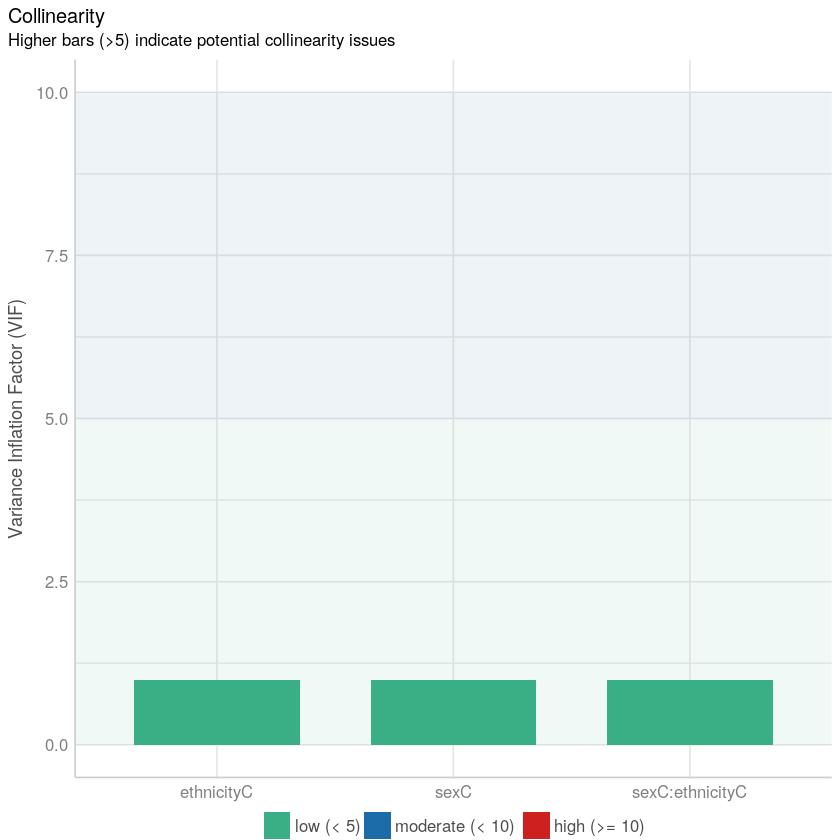

In [134]:
plot(check_collinearity(lmer_fl_uw_partial))

## Check singularity

In [135]:
check_collinearity(lmer_fl_uw_partial)

,Term,VIF,SE_factor
,<chr>,<dbl>,<dbl>
1,sexC,1.000056,1.000028
2,ethnicityC,1.000002,1.000001
3,sexC:ethnicityC,1.000054,1.000027


In [136]:
# https://rstudio-pubs-static.s3.amazonaws.com/33653_57fc7b8e5d484c909b615d8633c01d51.html


# https://rstudio-pubs-static.s3.amazonaws.com/33653_57fc7b8e5d484c909b615d8633c01d51.html
tt_p = getME(lmer_fl_uw_partial,"theta")
ll_p = getME(lmer_fl_uw_partial,"lower")
tt_value_p = min(tt_p[ll_p==0])

tt_value_p

[1] 0

In [137]:
theta_p <- getME(lmer_fl_uw_partial,"theta")
## diagonal elements are identifiable because they are fitted
##  with a lower bound of zero ...
diag.element <- getME(lmer_fl_uw_partial,"lower")==0
any(theta_p[diag.element]<1e-5)

# there may be a problem

[1] TRUE

## Three-way Anova 

In [138]:
df_free %>%
  group_by(ethnicity, sex, age) %>%
  get_summary_stats(sentimentScore, type = "mean_sd")

ethnicity,sex,age,variable,n,mean,sd
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
bipoc,female,adult,sentimentScore,1931,-0.091,0.390
bipoc,female,child,sentimentScore,1908,-0.023,0.404
bipoc,male,adult,sentimentScore,1953,-0.159,0.364
bipoc,male,child,sentimentScore,1902,-0.071,0.394
white,female,adult,sentimentScore,1908,-0.140,0.377
white,female,child,sentimentScore,1886,-0.047,0.393
white,male,adult,sentimentScore,1889,-0.114,0.361
white,male,child,sentimentScore,1899,-0.068,0.396


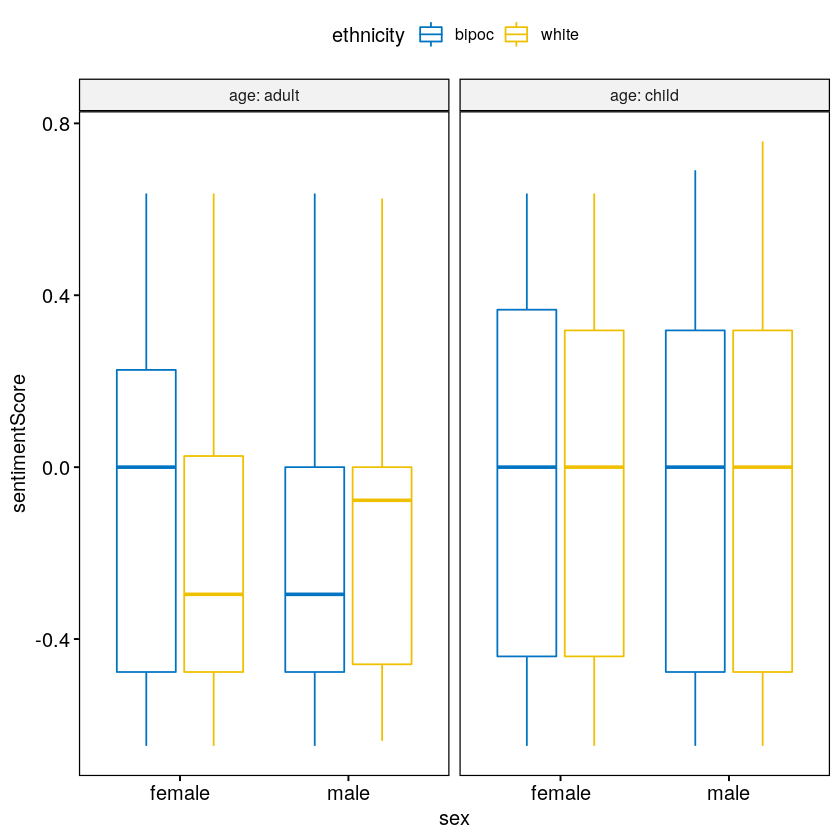

In [139]:
bxp_free <- ggboxplot(
  df_free, x = "sex", y = "sentimentScore",
  color = "ethnicity", palette = "jco",
  facet.by = "age", short.panel.labs = FALSE
  )
bxp_free

### Check assumptions

#### Outliers

In [140]:
df_free %>% group_by(ethnicity, sex, age) %>% identify_outliers(sentimentScore)
# just one not-extreme outlier

ethnicity,sex,age,participantId,photoId,emotion,label,url,sentimentScore,sexC,ageC,ethnicityC,is.outlier,is.extreme
<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>


#### Normality assumption

In [141]:
# Compute Shapiro-Wilk test for each combinations of factor levels

df_free %>%
  group_by(ethnicity, sex, age) %>%
  shapiro_test(sentimentScore)

ethnicity,sex,age,variable,statistic,p
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
bipoc,female,adult,sentimentScore,0.8912478,7.001136e-35
bipoc,female,child,sentimentScore,0.8911126,1.012841e-34
bipoc,male,adult,sentimentScore,0.8765328,8.337878e-37
bipoc,male,child,sentimentScore,0.8867083,3.249083e-35
white,female,adult,sentimentScore,0.8857009,2.205369e-35
white,female,child,sentimentScore,0.8970136,8.448279e-34
white,male,adult,sentimentScore,0.9064120,1.487511e-32
white,male,child,sentimentScore,0.8923242,1.686399e-34


#### QQ plot 

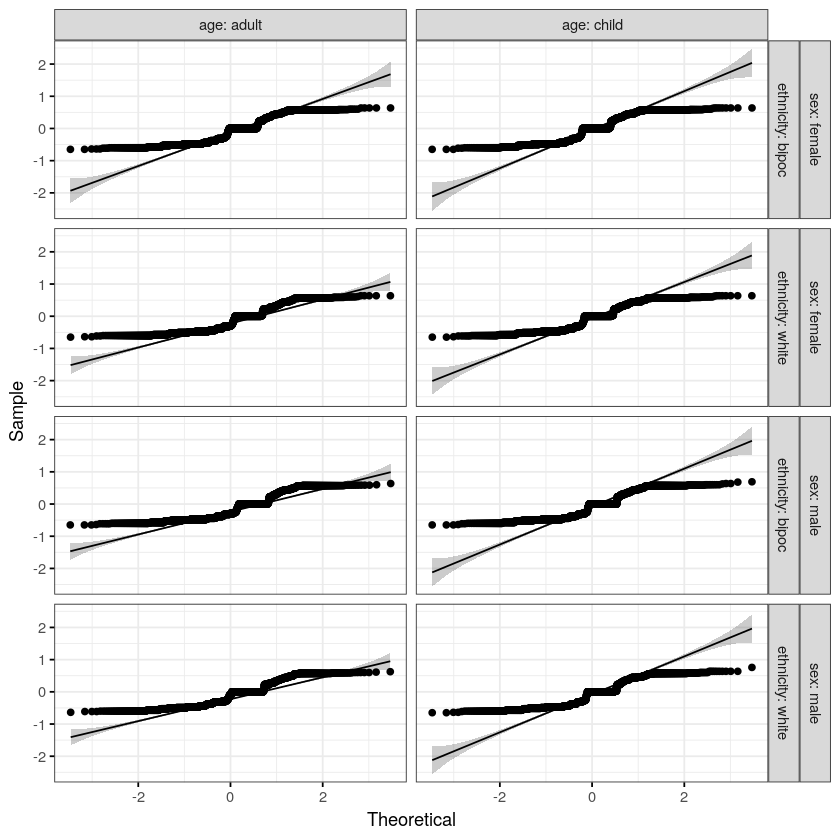

In [142]:
ggqqplot(df_free, "sentimentScore", ggtheme = theme_bw()) +
  facet_grid(sex + ethnicity ~ age, labeller = "label_both")

**Not normally distributed**

## Anova 2x2x2 computation 


In [143]:
df_long_free = df_free %>% select(participantId, sex, age, ethnicity, sentimentScore)
df_long_free = df_long_free %>% convert_as_factor(participantId, sex, age, ethnicity)
head(df_long_free)

participantId,sex,age,ethnicity,sentimentScore
<fct>,<fct>,<fct>,<fct>,<dbl>
0,female,adult,bipoc,-0.3182
0,male,adult,bipoc,-0.3182
0,male,adult,bipoc,-0.5719
0,male,adult,bipoc,0.2732
0,male,adult,bipoc,0.2732
0,male,adult,bipoc,-0.5719


In [144]:
res.aov  = ezANOVA(data=df_long_free, wid=.(participantId), dv=.(sentimentScore), within=.(sex, age, ethnicity))
res.aov  

Warning message:
“Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.”


,Effect,DFn,DFd,F,p,p<.05,ges
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
2,sex,1,49,18.799583,7.210064e-05,*,0.021053255
3,age,1,49,97.962728,2.829848e-13,*,0.118577260
4,ethnicity,1,49,3.623701,6.284403e-02,,0.003446383
5,sex:age,1,49,4.530234,3.835453e-02,*,0.002600076
6,sex:ethnicity,1,49,32.751555,6.236788e-07,*,0.023386960
7,age:ethnicity,1,49,4.068985,4.917320e-02,*,0.003215711
8,sex:age:ethnicity,1,49,6.912040,1.140498e-02,*,0.007216048


The three-way interactions between age, sex, and ethnicity, is significant, Anova, $F$(1, 49) = 6.91, $p$ < 0.01, $\eta^2_{g}=0.007$

### Post-hoc tests


#### simple two-way interaction

In [145]:
df_free_adult = df_free %>% filter(age=='adult')
df_free_child = df_free %>% filter(age=='child')

In [146]:
free_adult.twoway  = ezANOVA(data=df_free_adult, wid=.(participantId), dv= .(sentimentScore), within=.(sex, ethnicity))
free_child.twoway  = ezANOVA(data=df_free_child, wid=.(participantId), dv= .(sentimentScore), within=.(sex, ethnicity))

Warning message:
“Converting "participantId" to factor for ANOVA.”
Warning message:
“Converting "sex" to factor for ANOVA.”
Warning message:
“Converting "ethnicity" to factor for ANOVA.”
Warning message:
“Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.”
Warning message:
“Converting "participantId" to factor for ANOVA.”
Warning message:
“Converting "sex" to factor for ANOVA.”
Warning message:
“Converting "ethnicity" to factor for ANOVA.”
Warning message:
“Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.”


In [147]:
free_adult.twoway

,Effect,DFn,DFd,F,p,p<.05,ges
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
2,sex,1,49,8.125008329,6.370744e-03,*,1.243957e-02
3,ethnicity,1,49,0.003740261,9.514824e-01,,5.561871e-06
4,sex:ethnicity,1,49,31.245499694,9.964392e-07,*,7.356160e-02


In [148]:
free_child.twoway

,Effect,DFn,DFd,F,p,p<.05,ges
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
2,sex,1,49,16.890904,0.0001502439,*,0.029755252
3,ethnicity,1,49,5.532557,0.0227281228,*,0.010376953
4,sex:ethnicity,1,49,2.804497,0.1003721035,,0.003774643


There is statistically significant simple two-way interaction between **sex** and **ethnicity** for "adults", F(1, 49) = 31.25, p < 0.0001, but not for "childrens", F(1, 49) = 2.8,  p = 0.1

#### Simple main effect

In [149]:
df_free_adult_male = df_free_adult %>% filter(sex=='male')
df_free_adult_female = df_free_adult %>% filter(sex=='female')
df_free_child_male = df_free_child %>% filter(sex=='male')
df_free_child_female = df_free_child %>% filter(sex=='female')

In [150]:
free_adult_male.main  = ezANOVA(data=df_free_adult_male, wid=.(participantId), dv= .(sentimentScore), within=.(ethnicity))
free_adult_female.main  = ezANOVA(data=df_free_adult_female, wid=.(participantId), dv= .(sentimentScore), within=.(ethnicity))
free_child_male.main  = ezANOVA(data=df_free_child_male, wid=.(participantId), dv= .(sentimentScore), within=.(ethnicity))
free_child_female.main  = ezANOVA(data=df_free_child_female, wid=.(participantId), dv= .(sentimentScore), within=.(ethnicity))

Warning message:
“Converting "participantId" to factor for ANOVA.”
Warning message:
“Converting "ethnicity" to factor for ANOVA.”
Warning message:
“Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.”
Warning message:
“Converting "participantId" to factor for ANOVA.”
Warning message:
“Converting "ethnicity" to factor for ANOVA.”
Warning message:
“Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.”
Warning message:
“Converting "participantId" to factor for ANOVA.”
Warning message:
“Converting "ethnicity" to factor for ANOVA.”
Warning message:
“Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.”
Warning message:
“Converting "participantId" to factor for AN

In [151]:
free_adult_male.main  

,Effect,DFn,DFd,F,p,p<.05,ges
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
2,ethnicity,1,49,36.23304,2.184859e-07,*,0.08781556


In [152]:
free_adult_female.main

,Effect,DFn,DFd,F,p,p<.05,ges
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
2,ethnicity,1,49,13.68044,0.000547863,*,0.0635881


In [153]:
free_child_male.main  

,Effect,DFn,DFd,F,p,p<.05,ges
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
2,ethnicity,1,49,0.5733771,0.452546,,0.00181172


In [154]:
free_child_female.main

,Effect,DFn,DFd,F,p,p<.05,ges
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
2,ethnicity,1,49,7.502595,0.008567537,*,0.02426797


There is a statistically significant simple main effect of **ethnicity** on **sentiment-score** for the "**adult-males**" group, F(1, 49) = 36.23, for the "**adult-females**" group, F(1, 49) = 13.68, p < 0.0001, and for the **child-female** group, F(1, 49) = 7.5, p = 0.008.

#### Simple pairwise comparisons

In [155]:
pwc <- df_free %>%
  group_by(age, sex) %>%
  pairwise_t_test(sentimentScore ~ ethnicity, paired = FALSE, p.adjust.method = "bonferroni") 

pwc

,sex,age,.y.,group1,group2,n1,n2,p,p.signif,p.adj,p.adj.signif
,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<chr>,<dbl>,<chr>
1,female,adult,sentimentScore,bipoc,white,1931,1908,7.44e-05,****,7.44e-05,****
2,male,adult,sentimentScore,bipoc,white,1953,1889,1.32e-04,***,1.32e-04,***
3,female,child,sentimentScore,bipoc,white,1908,1886,6.04e-02,ns,6.04e-02,ns
4,male,child,sentimentScore,bipoc,white,1902,1899,8.07e-01,ns,8.07e-01,ns


### Visualization free-labeling: box plots with p-values

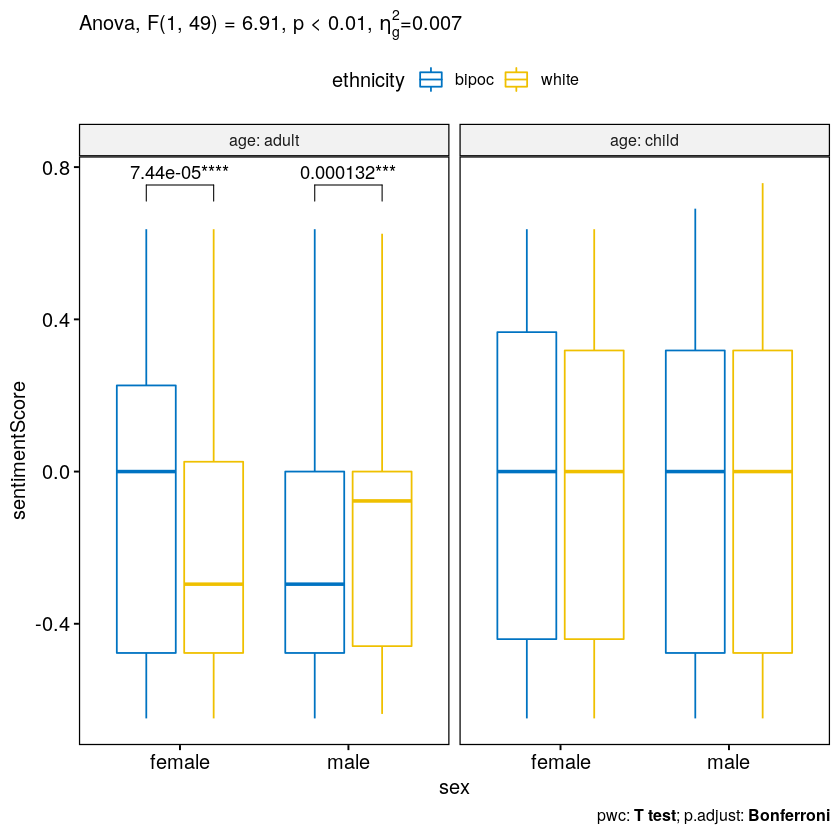

In [156]:
# subtitle_3way_anova = Anova, $F$(1, 49) = 6.91, $p$ < 0.01, $\eta^2_{g}=0.007$
subtitle_3way_anova_free = expression(paste("Anova, F(1, 49) = 6.91, p < 0.01, ",eta[g]^2, "=0.007"))
pwc <- pwc %>% add_xy_position(x = "sex")

bxp_free +  
  stat_pvalue_manual(
    pwc, hide.ns = TRUE, bracket.nudge.y = 0.1,
    label = "{p.adj}{p.adj.signif}"
    ) +
  labs(
    subtitle = subtitle_3way_anova_free,
    caption = get_pwc_label(pwc)
  )

In [157]:
# # subtitle_3way_anova = Anova, $F$(1, 49) = 6.91, $p$ < 0.01, $\eta^2_{g}=0.007$
# subtitle_3way_anova_free = expression(paste("Anova, F(1, 49) = 6.91, p < 0.01, ",eta[g]^2, "=0.007"))
# pwc <- pwc %>% add_xy_position(x = "sex")

# pwc.filtered <- pwc %>% 
#   filter((sex == "male" & age == "adult") | (sex == "female" & age == "child"))

# bxp_free +  
#   stat_pvalue_manual(
#     pwc.filtered, hide.ns = TRUE, bracket.nudge.y = 0.1,
#     label = "{p.adj}{p.adj.signif}"
#     ) +
#   labs(
#     subtitle = subtitle_3way_anova_free,
#     caption = get_pwc_label(pwc)
#   )

In [158]:
ggsave("../clean_data_mturk/anova_3way_test_free_labeling_mturk.png")
ggsave("../../emotions_dashboard/data/anova_3way_test_free_labeling_mturk.png")

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

